In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
class GradientDescent:
    def __init__(self, data, alpha=.001, gamma=.9, beta1=.9, beta2=.999, e=1e-8):
        self.data = data
        self.alpha = alpha
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2
        self.e = e
        self.stepCount = 1
        self.steps = []


    # h(x) = theta0 + theta1 * x1  ....thetan * xn
    """
    x0 = 1
    |1 x1 x2| |theta0|   |y^0|
    |.......| |theta1| = |y^1|
    |.......| |theta2|   |y^2|
    """
    def hypo(self, x0, x):
        hX = x @ x0
        return hX

    # calculate cost
    """
    cost = sum((predicted - y) ** 2) / 2m
    cost = error.T @ error /2m

    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    2/m * |e1 e2 e3| |e1|
                     |e2| = [cost]
                     |e3|

    """

    def CostFunction(self, hX, y):
        error = (hX - y)
        cost = (error.T @ error) /(2*hX.shape[0])
        return cost


    # calculate partial derivative for each parameter
    """
    gradient = (sum(predicted - y) * x)/m
    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    gradient = X.T * error
    |x0 ......| |e1|   |g0|
    |x1 ......| |e2| = |g1|
    |x2 ......| |e3|   |g2|
    """
    def Gradient(self, hX, Y, X):
        m = X.shape[0]
        error = hX - Y
        return (X.T @ error) / m

    def updateTheta(self, x0, gradient, mT=None, vT=None, opt=None, x=None, y=None, stepCount=None):
        # default step(optimizer)
        if opt is None:
            x0 = x0 - (self.alpha * gradient)
            return x0

        # momentum based step
        elif opt == "mT":
            mT = self.gamma * mT + self.alpha * gradient
            x0 = x0 - mT
            return x0, mT

        # Nestrove accelrated gradient
        elif opt == "NAG":
            # calculate theta temp to look in first
            xTemp = x0 - self.gamma * mT
            # evaluate h(x) at theta temp
            hXTemp = self.hypo(xTemp, x)
            # calculate gradient at theta temp
            xTempGrad = self.Gradient(hXTemp, y, x)
            # update theta based on theta temp
            x0 = xTemp - self.alpha * xTempGrad
            mT = self.gamma * mT + self.alpha * xTempGrad

            return x0, mT

        elif opt == "ADGRAD":
            vT = vT + gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "RMSP":
            vT = self.gamma * vT + (1 - self.gamma) * gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "ADAM":
            # mt
            mT = self.beta1 * mT + (1 - self.beta1) * gradient
            # vt
            vT = self.beta2 * vT + (1 - self.beta2) * gradient**2
            # bias correction
            mT_ = mT / (1 - np.power(self.beta1, stepCount))
            vT_ = vT / (1 - np.power(self.beta2, stepCount))

            # update the vector
            x0 = x0 - ((self.alpha / (np.sqrt(vT_) + self.e)) * mT_)
            return x0, vT, mT


    #------------------------------------------------#
    def prepareData(self, opt=None):
        # shuffle data
        np.random.shuffle(self.data)
        # inital theta vector
        n = self.data.shape[1]
        x0 = np.zeros((n, 1))
        # create vector column of ones for theta0
        ones = np.ones_like(self.data[:, [0]])
        # build up matrix from x data and ones vector
        X = np.c_[ones, self.data[:, :-1]]
        # true y value is the last column in the data
        Y = self.data[:, [-1]]

        # Momentum and Nestrov
        if opt == "mT" or opt == "NAG":
            mT = np.zeros_like(x0)
            return X, Y, x0, mT

        # ADAM
        elif opt == "ADAM":
            vT = np.zeros_like(x0)
            mT = np.zeros_like(x0)
            return X, Y, x0, vT, mT

        # ADGRAD and RMSP
        elif opt == "ADGRAD" or opt == "RMSP":
            vT = np.zeros_like(x0)
            return X, Y, x0, vT


        return X, Y, x0


    def fit(self, size=None, opt=None, epochs=None):
        if epochs is None:
            k = 10000

        # batch size equall full data if not given
        if size is None:
            size = self.data.shape[0]

        self.stepCount = 1
        self.steps.clear()
        oldCost = None

        # grab the data
        if opt == "mT" or opt == "NAG":
            X, Y, x0, mT = self.prepareData(opt="mT")
        elif opt == "ADGRAD" or opt == "RMSP":
            X, Y, x0, vT = self.prepareData(opt="ADGRAD")
        elif opt == "ADAM":
            X, Y, x0, vT, mT = self.prepareData(opt="ADAM")
        else:
            X, Y, x0 = self.prepareData()

        # number of batches
        nb = self.data.shape[0] // size if self.data.shape[0] % size == 0 else (self.data.shape[0]//size) + 1
        for i in range(0, k):
            bT = 0
            for i in range(0, nb):
                xBatch = X[bT: bT+size, :]
                yBatch = Y[bT: bT+size, :]
                # calculate h(x)
                hX = self.hypo(x0, xBatch)

                # calculate cost
                newCost = self.CostFunction(hX, yBatch)

                # calculate gradient at current x
                gradient = self.Gradient(hX, yBatch, xBatch)
                # update the vector
                if opt == "mT":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="mT")
                elif opt == "NAG":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="NAG", x=xBatch, y=yBatch)
                elif opt == "ADGRAD":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="ADGRAD")
                elif opt == "RMSP":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="RMSP")
                elif opt == "ADAM":
                    x0, vT, mT = self.updateTheta(x0, gradient, vT=vT, mT=mT, opt="ADAM", stepCount=self.stepCount)
                else:
                    x0 = x0 - (self.alpha * gradient)

                # update step
                self.stepCount +=1

                iterData = {"theta": x0, "cost": newCost, "steps": hX}
                self.steps.append(iterData)

                # update the size
                bT += size

            # break condition "no update in the cost
            if oldCost is not None and abs(newCost - oldCost) <= 1e-3 or abs(np.linalg.norm(gradient)) < 1e-3:
                break
            # save the current cost in the oldCost variable
            oldCost = newCost

        plt_hX = self.hypo(x0, X)
        self.plot(opt, size, plt_hX)

    def r2_score(self):
        bf = self.steps[-1]["theta"]
        ones = np.ones((self.data.shape[0], 1))
        M = np.c_[ones, self.data[:, :-1]]
        y_ = M @ bf
        score = r2_score(y_, self.data[:, [-1]])
        return score

    def plot_theta(self):
        X = len(self.steps[0]['theta'])
        if X < 4:
            nC = X
        else:
            nC = 4
        nR = X // 4 if X % 4 == 0 else X//4 + 1
        fig, axes = plt.subplots(nrows=nR, ncols=nC, figsize=(20, nR*6))
        c = 0
        r = 0
        cost = [x['cost'][0] for x in self.steps]
        for i in range(0, X):
            theta = [x['theta'][i] for x in self.steps]
            if nR == 1:
                axes[c].plot(theta, cost)
                axes[c].set_xlabel(f'Theta {i}', fontsize=16).set_color('darkred')
                axes[c].set_ylabel('Cost', fontsize=16).set_color('darkred')
                axes[c].grid()

            else:
                axes[r, c].plot(theta, cost)
                axes[r, c].set_xlabel(f'Theta {i}', fontsize=16).set_color('darkred')
                axes[r, c].set_ylabel('Cost', fontsize=16).set_color('darkred')
                axes[r, c].grid()
            if c < nC-1:
                c += 1
            else:
                r += 1
                c = 0
        fig.suptitle("Cost vs Theta")
        fig.tight_layout()

    def plot(self, opt, batch, plt_hX):
        x = self.data[:, [0]]
        y = self.data[:, [1]]
        xCost = list(range(len(self.steps)))
        yCost = [s["cost"][0][0] for s in self.steps]
        fig = plt.figure(figsize=(18, 8))


        ax2 = fig.add_subplot(122)
        ax2.plot(xCost, yCost, label="MSE")
        ax2.set_title("MSE vs iterations")
        ax2.set_xlabel("Iteration", fontsize=16).set_color('darkred')
        ax2.set_ylabel("MSE", fontsize=16).set_color('darkred')

        if self.data.shape[1] == 2:
            ax1 = fig.add_subplot(121)
            ax1.scatter(x, y, label="Date point")
            ax1.plot(x, plt_hX, label="Regression Line", color='red')

            ax1.set_xlabel("X", fontsize=16).set_color('darkred')
            ax1.set_ylabel("Y", fontsize=16).set_color('darkred')
            ax1.set_title("Regression Line")
            ax1.grid()
        ax2.grid()
        plt.legend()
        plt.show();
        if opt is None:
            opt = "Normal GD"
        score = self.r2_score()
        print("r2_score: ", score)
        print("Cost at minimum: ", self.steps[-1]['cost'][0][0])
        print("Optimizer: ", opt)
        print("Batch size: ", batch)
        print("Total number of iterations: ", self.stepCount - 1 // batch)
        print("alpha: ", self.alpha)
        if opt == "ADAM":
            print(f"gamma: {self.gamma} | beta1: {self.beta1} | beta2: {self.beta2}")
        if opt == "RMSP" or opt == "mT" or opt == "NAG":
            print(f"gamma: {self.gamma}")
        print("Optimal thetas values:\n", self.steps[-1]["theta"])


In [ ]:
# open data file and extract data
Data = np.genfromtxt(r"Omitted :D", delimiter=',')

## Adam Batch version

## Description on parameters of fitting
- size -> indicates the batch size if the size is not provided the size will be the whole data (Batch gradient Descent), for stochastic pass batch size is 1
- epochs -> desired number of iteration before stopping the iterations default = 10000
- opt -> to combine different updata optmizers default is normal gradient descent updata
- available
    1) mT = Momentum update of theta
    2) NAG = Nestrov accelerated gradient descent
    3) ADAGRAD = Adaptive gradient
    4) RMSP = RMSProp optmizer
    5) ADAM = ADAM optmizer

    

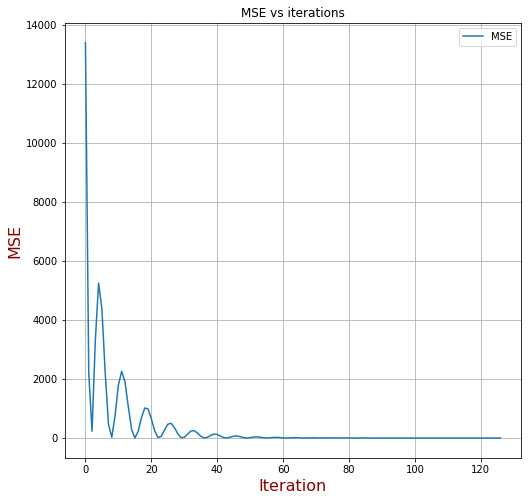

r2_score:  0.9828017618387838
Cost at minimum:  4.561457580092147
Optimizer:  ADAM
Batch size:  25
Total number of iterations:  128
alpha:  0.4
gamma: 0.9 | beta1: 0.9 | beta2: 0.99
Optimal thetas values:
 [[0.61715155]
 [0.60495146]
 [0.60258146]
 [0.80952073]]


In [ ]:
Adam_batch = GradientDescent(Data, alpha=.4, gamma=.9, beta1=.9, beta2=.99)
Adam_batch.fit(opt='ADAM')

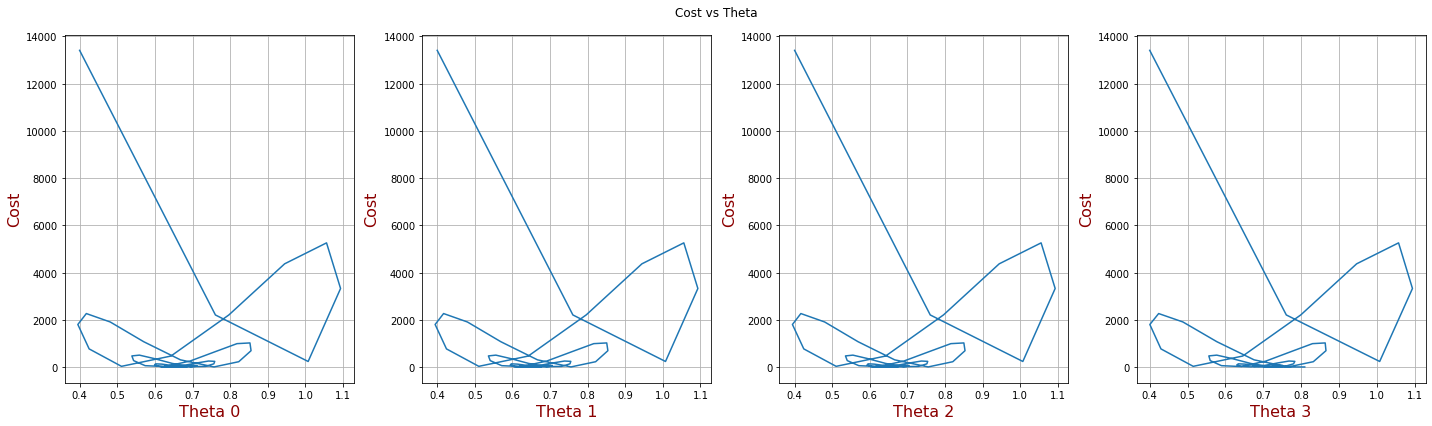

In [ ]:
Adam_batch.plot_theta()

## MiniBatch ADAM

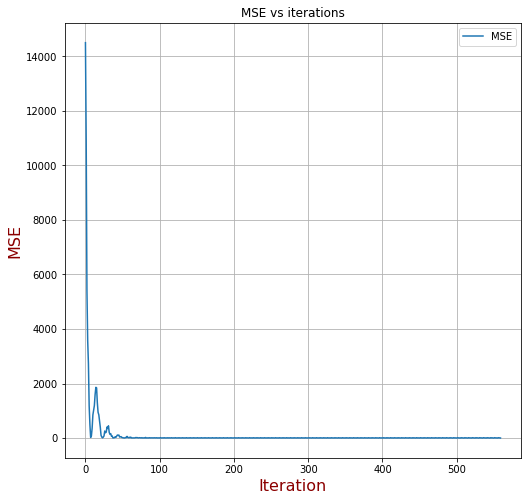

r2_score:  0.9847563558356366
Cost at minimum:  1.5115214200088398
Optimizer:  ADAM
Batch size:  5
Total number of iterations:  561
alpha:  0.1
gamma: 0.9 | beta1: 0.9 | beta2: 0.99
Optimal thetas values:
 [[0.04572743]
 [0.45353655]
 [0.48466637]
 [1.06124269]]


In [ ]:
Adam_mini_batch = GradientDescent(Data, alpha=.1, gamma=.9, beta1=.9, beta2=.99)
Adam_mini_batch.fit(size=5, opt='ADAM')

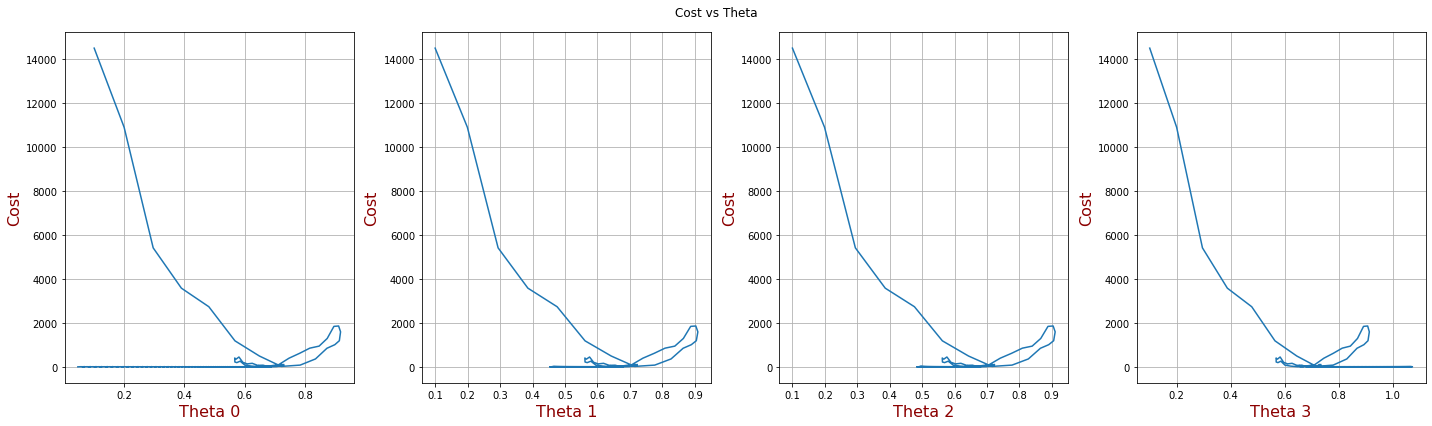

In [ ]:
Adam_mini_batch.plot_theta()